<a href="https://colab.research.google.com/github/andrebelem/ASTOC/blob/main/SNIPPETS_1_Dados_Maregr%C3%A1ficos_%5Bquick_dirty%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aqui vamos explorar algumas técnicas 'simples' de limpeza de dados de uma série de nível. **Nota**: aqui talvez tenha menos de "1%" de técnicas do que podemos fazer com os dados para limpá-los.<br>

Vamos basicamente copiar nossa receita de bolo para baixar os dados do marégrafo da DHN em um determinado período de tempo.

In [6]:
import pandas as pd
import urllib
import json
from datetime import datetime

time1 = datetime(2023, 6, 1).timestamp() # note que a construção agora usa *timestamp*
time2 = datetime(2023, 12, 31).timestamp()

print(f'Recuperando dados nos tempos:\n'\
      f'time2 = {datetime.fromtimestamp(time1).strftime("%Y-%m-%d %H:%M:%S")}\n'\
      f'time1 = {datetime.fromtimestamp(time2).strftime("%Y-%m-%d %H:%M:%S")}')

url = f'https://simcosta.furg.br/api/intrans_data?boiaID=304&type=json&time1={int(time1)}&time2={int(time2)}&params=water_l1,avg_water_l1'

df = pd.json_normalize(json.loads(urllib.request.urlopen(url).read()))
df = df.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND'])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head(5)
df.index = df['timestamp'] # transforma o timestamp no index
print(f'o Delta-T dos perfis é {df["timestamp"].diff().median()}')

Recuperando dados nos tempos:
time2 = 2023-06-01 00:00:00
time1 = 2023-12-31 00:00:00
o Delta-T dos perfis é 0 days 00:01:00


O plot será sempre o mesmo. Note que decidi ir adicionando novas colunas ao dataframe para cada passo de limpeza. Isso é bastante útil quando temos um datetime como index e queremos comparar diferentes técnicas de limpeza.

<Axes: xlabel='data', ylabel='AVg Water Level [cm]'>

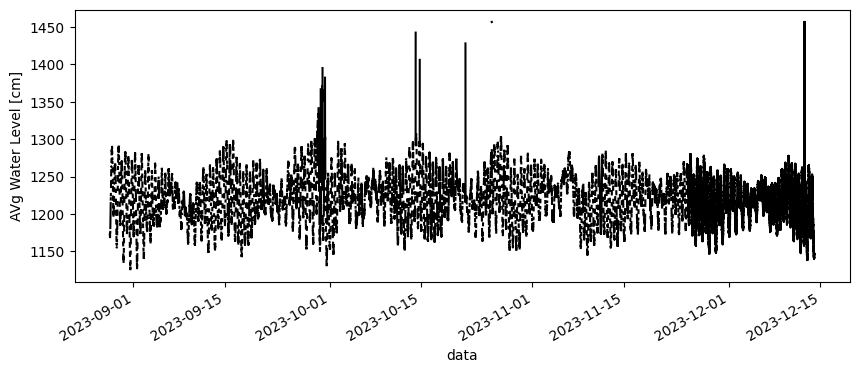

In [9]:
df.avg_water_l1.plot(color='k',xlabel='data',ylabel='AVg Water Level [cm]',figsize=(10,4))

<Axes: xlabel='data', ylabel='AVg Water Level [cm]'>

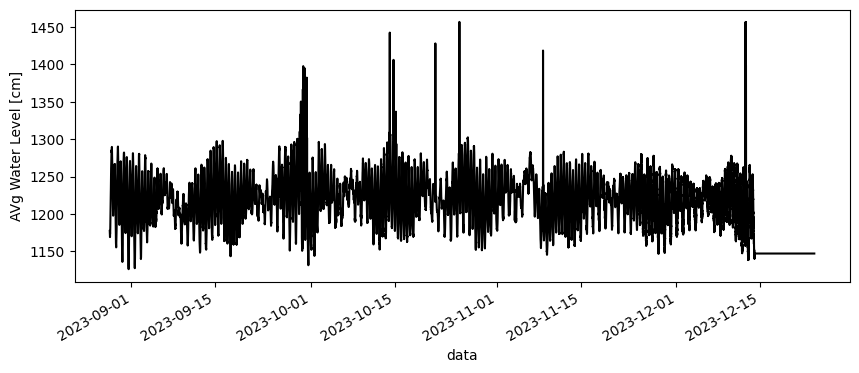

In [10]:
# Preenchimento usando interpolação linear
df['avg_water_l1_interp'] = df['avg_water_l1'].interpolate(method='linear')
df.avg_water_l1_interp.plot(color='k',xlabel='data',ylabel='AVg Water Level [cm]',figsize=(10,4))

<Axes: xlabel='data', ylabel='AVg Water Level [cm]'>

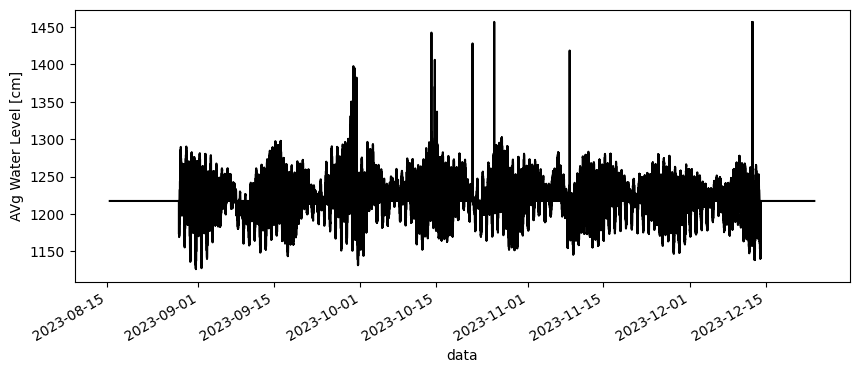

In [11]:
# Preenchimento por média
mean_value = df['avg_water_l1'].mean()
df['avg_water_l1_mean_filled'] = df['avg_water_l1'].fillna(mean_value)

# Preenchimento por mediana
#median_value = df['avg_water_l1'].median()
#df['avg_water_l1_median_filled'] = df['avg_water_l1'].fillna(median_value)
df.avg_water_l1_mean_filled.plot(color='k',xlabel='data',ylabel='AVg Water Level [cm]',figsize=(10,4))

<Axes: xlabel='data', ylabel='AVg Water Level [cm]'>

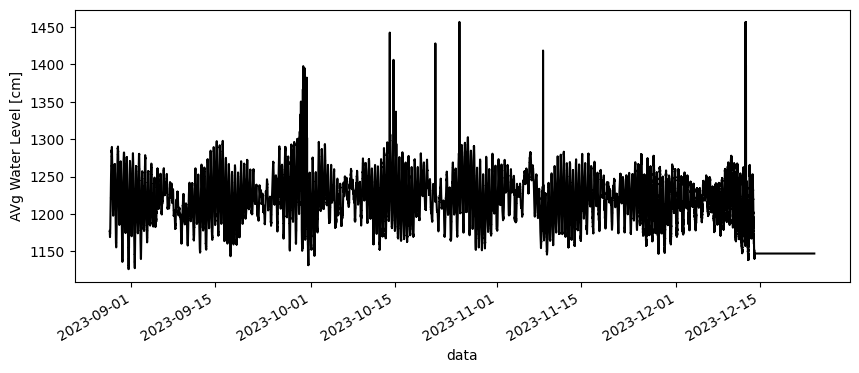

In [12]:
# Preenchimento para frente (preenchimento com o último valor válido)
df['avg_water_l1_ffill'] = df['avg_water_l1'].fillna(method='ffill')

# Preenchimento para trás (preenchimento com o próximo valor válido)
#df['avg_water_l1_bfill'] = df['avg_water_l1'].fillna(method='bfill')
df.avg_water_l1_ffill.plot(color='k',xlabel='data',ylabel='AVg Water Level [cm]',figsize=(10,4))


<Axes: xlabel='data', ylabel='AVg Water Level [cm]'>

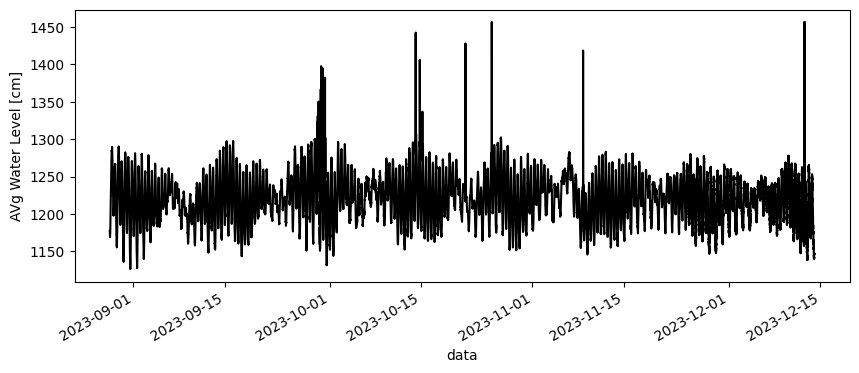

In [13]:
# Preenchimento usando interpolação baseada em vizinhos mais próximos
df['avg_water_l1_nearest'] = df['avg_water_l1'].interpolate(method='nearest')

# Preenchimento usando interpolação cúbica
#df['avg_water_l1_cubic'] = df['avg_water_l1'].interpolate(method='cubic')
df.avg_water_l1_nearest.plot(color='k',xlabel='data',ylabel='AVg Water Level [cm]',figsize=(10,4))

Alguns pontos espúrios ainda aparecem. Será que conseguimos retira-los ?

<Axes: xlabel='data', ylabel='AVg Water Level [cm]'>

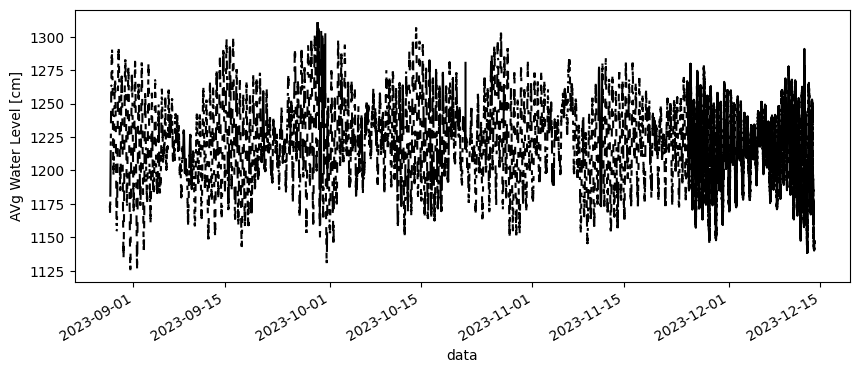

In [15]:
import numpy as np
# Calcular o Z-score
z_scores = np.abs((df['avg_water_l1'] - df['avg_water_l1'].mean()) / df['avg_water_l1'].std())

# Definir um limite para identificar outliers (por exemplo, Z-score maior que 3)
outlier_threshold = 3

# Substituir outliers pelo valor NaN
df['avg_water_l1_outliers_removed'] = df['avg_water_l1']
df.loc[z_scores > outlier_threshold, 'avg_water_l1_outliers_removed'] = np.nan

df.avg_water_l1_outliers_removed.plot(color='k',xlabel='data',ylabel='AVg Water Level [cm]',figsize=(10,4))

<Axes: xlabel='data', ylabel='AVg Water Level [cm]'>

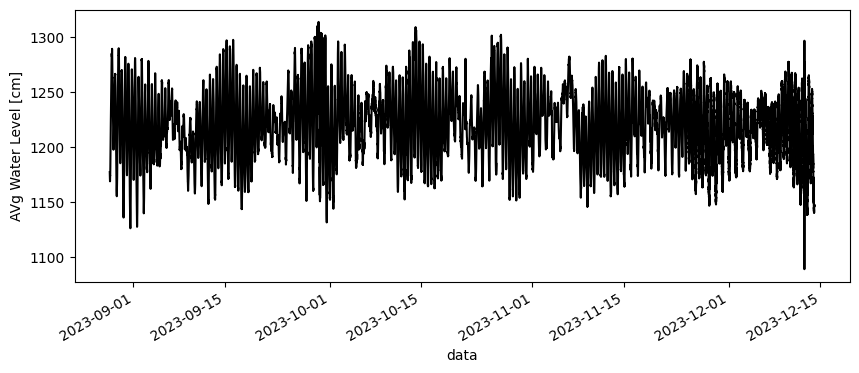

In [16]:
# e dai vamos reconstruir essa série novamente
# Preenchimento usando interpolação cúbica
df['avg_water_l1_cubic'] = df['avg_water_l1_outliers_removed'].interpolate(method='cubic')
df.avg_water_l1_cubic.plot(color='k',xlabel='data',ylabel='AVg Water Level [cm]',figsize=(10,4))

Note que apareceu um outlier "mínimo local". Isso acontece justamente porque estamos usando o método de interpolação cúbica. Vou deixar assim aqui mas note que há maneiras melhores de se interpolar para evitar isso. **Dica**: Use sua criatividade.

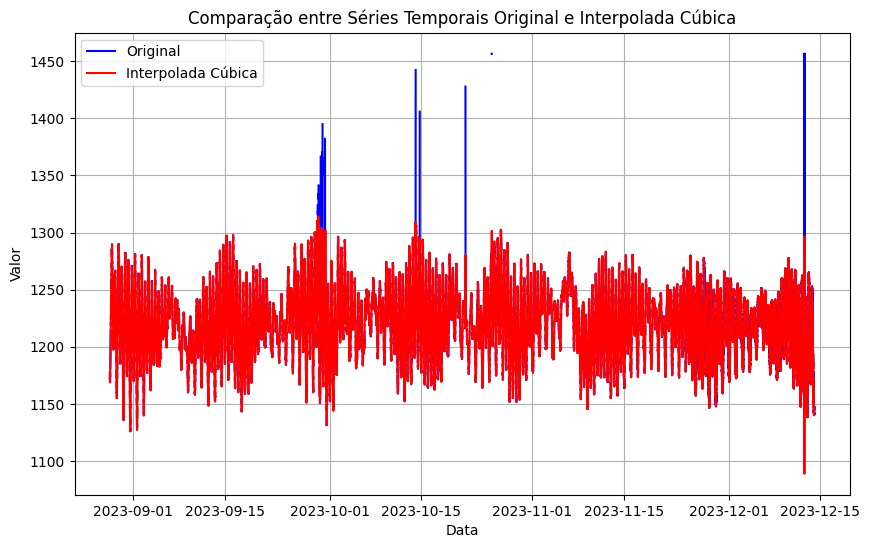

In [17]:
import matplotlib.pyplot as plt

# Criando uma nova figura
plt.figure(figsize=(10, 6))

# Plotando a série temporal 'avg_water_l1'
plt.plot(df.index, df['avg_water_l1'], label='Original', color='blue')

# Plotando a série temporal 'avg_water_l1_cubic'
plt.plot(df.index, df['avg_water_l1_cubic'], label='Interpolada Cúbica', color='red')

# Adicionando legendas e rótulos
plt.title('Comparação entre Séries Temporais Original e Interpolada Cúbica')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()

# Mostrar o gráfico
plt.grid(True)
plt.show()


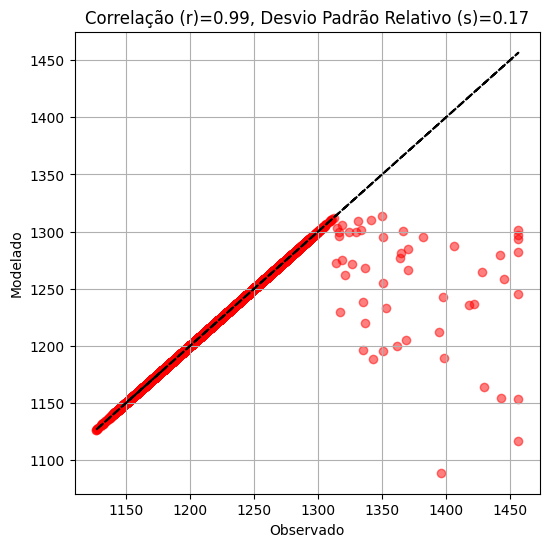

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Encontrar índices onde ambas as séries têm valores não-NaN
valid_indices = np.logical_and(~np.isnan(df['avg_water_l1'].values), ~np.isnan(df['avg_water_l1_cubic'].values))

# Filtrar os valores não-NaN em ambas as séries usando os índices válidos
observed_cleaned = df['avg_water_l1'].values[valid_indices]
modeled_cleaned = df['avg_water_l1_cubic'].values[valid_indices]

# Calcular a correlação de Pearson (r)
r = np.corrcoef(observed_cleaned, modeled_cleaned)[0, 1]

# Calcular o desvio padrão relativo (s)
s = np.std(modeled_cleaned - observed_cleaned) / np.std(observed_cleaned)

# Plotar o diagrama de dispersão
plt.figure(figsize=(6, 6))
plt.scatter(observed_cleaned, modeled_cleaned, color='r', alpha=0.5)
plt.xlabel('Observado')
plt.ylabel('Modelado')
plt.title('Correlação (r)={:.2f}, Desvio Padrão Relativo (s)={:.2f}'.format(r, s))

# Adicionar linha de referência
plt.plot(observed_cleaned, observed_cleaned, color='k', linestyle='--')

# Exibir o gráfico
plt.grid(True)
plt.show()


Dica 'desafio': Se você quiser, você pode ainda instalar o pacote SkillMetrics ou outro Diagrama de Taylor similar, e testar as diferentes técnicas de interpolação e os seus respectivos resultados.